# Rice Classification: Classifying a Grain of Rice with Neutral Physical Properties
### DSCI100: Project Proposal (Group 124)

##### Sean Park (66350992)
##### Deacon Sowerby (50471499)
##### Gabriel Reyes (80274921)
##### David Rao (55832919)

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows=10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1. Introduction

### -> About the dataset
Different types of rice are classified biologically by their origin; however, some of these types can also be identified by their physical shape. In our dataset, "riceClassification.csv", there are more than 18,000 observations of rice grains with specified physical measurements that classify as either the rice type "**Gonen**' (indicated by the factor 0) or "**Jasmine**" (indicated by the factor 1). This data has been produced for the specific purpose of binary classification.

In [2]:
url = "https://raw.githubusercontent.com/sean-prk/dsci-group-project-report/main/riceClassification.csv"
# referenced a csv file from our own GitHub repository

download.file(url, "riceClassification.csv")

# we tidied the data here to be able to explain our objective more clearly
rice_data <- read_csv("riceClassification.csv") |>
    mutate(Class = as_factor(Class)) |>
    select(id:Class)
rice_data

Rows: 18186 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): ...1, id, Area, MajorAxisLength, MinorAxisLength, Eccentricity, Co...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,4537,92.22932,64.01277,0.7199162,4677,76.00452,0.6575362,273.085,0.7645096,1.440796,1
2,2872,74.69188,51.40045,0.7255527,3015,60.47102,0.7130089,208.317,0.8316582,1.453137,1
3,3048,76.29316,52.04349,0.7312109,3132,62.29634,0.7591532,210.012,0.8684336,1.465950,1
4,3073,77.03363,51.92849,0.7386387,3157,62.55130,0.7835288,210.657,0.8702031,1.483456,1
5,3693,85.12478,56.37402,0.7492816,3802,68.57167,0.7693750,230.332,0.8747433,1.510000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
18182,5853,148.6246,51.02928,0.9392099,6008,86.32654,0.4985944,332.960,0.6634440,2.912535,0
18183,7585,169.5940,58.14166,0.9393980,7806,98.27269,0.6474605,385.506,0.6413619,2.916910,0
18184,6365,154.7771,52.90808,0.9397603,6531,90.02316,0.5612875,342.253,0.6828318,2.925396,0


### -> Our objective

We will focus on this specific rice observation in our dataset sliced below (id=9056), which we will store in the variable "test_obs". Despite it being classified as Gonen (0), we noticed that the measurements for this observation seems fairly neutral between the two classes; in other words, it is difficult to predict the class of this observation with confidence, as its measurements are not too swayed in favour of either class (see plots displayed under "visualizations" below).

In [3]:
test_obs <- rice_data |>
    slice(9056)
test_obs

id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
9056,7036,151.6808,59.80785,0.9154064,7225,94.13249,0.6166529,351.607,0.7079983,2.599081,0


Therefore, we will build a classifier that classifies a rice grain as either Gonen or Jasmine given its physical properties. Using this classifier, we want to predict the class of this test_obs, and check if our classifier will be able to accurately determine its real class, despite its seemingly neutral properties.

### -> Our question
**Which class, either Gonen or Jasmine, will this seemingly neutral observation be classified as?**
Does it match its real class? Is the prediction accurate enough to trust our answer?

### -> Our thesis

We expect our test observation to be classified as its true class, **"Gonen (0)")**. Since the measurement distribution between the two classes in this dataset are visibly distinct (as the dataset was intended for binary classification) and because there are thousands of observations for our classifier to reference, our classifier will most likely have a high accuracy. Therefore, although the measurements are seemingly neutral, there is a greater chance that this observation will be correctly classified.

## 2. Methods and Results

### -> Pre-analysis

Note that we have already loaded in and tidied our dataset (in the variable "rice_data", and we have pulled the observation that we wish to test for our result (in the variable "test_obs"). See the introduction above for renderings of these data.

### -> Summary by class

Figure 1 below shows the mean value for all variables in the dataset, summarized by each class. The observation which we will classify at the end, test_obs, is also provided for comparison.

In [4]:
# Figure 1
rice_summary <- rice_data |>
    group_by(Class) |>
    summarize(Count = n(), across(c(Area:AspectRation), ~ mean(.x, na.rm = TRUE)))
rice_summary
test_obs

Class,Count,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8201,8358.380,153.6982,69.99619,0.8888024,8575.131,102.97909,0.6516016,368.9643,0.7697687,2.199647
1,9985,5950.785,150.0238,51.43984,0.9372571,6117.584,86.86733,0.5879483,337.3508,0.6572644,2.927149


id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
9056,7036,151.6808,59.80785,0.9154064,7225,94.13249,0.6166529,351.607,0.7079983,2.599081,0


Through this table, we are able to identify which variables have very clear differences in means between the two classes; for example, the variable **Area** shows a distinct difference between the average values of Gonen (approx. 8000) and Jasmine (approx. 6000). Meanwhile, we can see that **MajorAxisLength** does not display a significant difference between the average values of the two classes (Gonen: approx. 153; Jasmine: approx. 150). This could help us identify which predictors would be most effective for our classifier.

Additionally, we can see how test_obs has values that are about in the center of these two means; as a result, it is hard to classify this observation just by looking at its numerical measurements.

### -> Visualiations

To further emphasize the idea presented in the summary table, the following plots demonstrate each class' distribution of values within each variable. We paired the variables in a scatterplot to recognize any significant relationships that may occur. The highlighted point in each plot represents the "neutral" observation (test_obs) that we will be predicting for our project. 
In order, the following tables represent the data's relationship between

1. MajorAxisLength and MinorAxisLength
2. Area and ConvexArea
3. EquivDiameter and Diameter
4. Eccentricity and Roundness
5. EquivDiameter and Extent.

Note that **0=Gonen, and 1=Jasmine**.

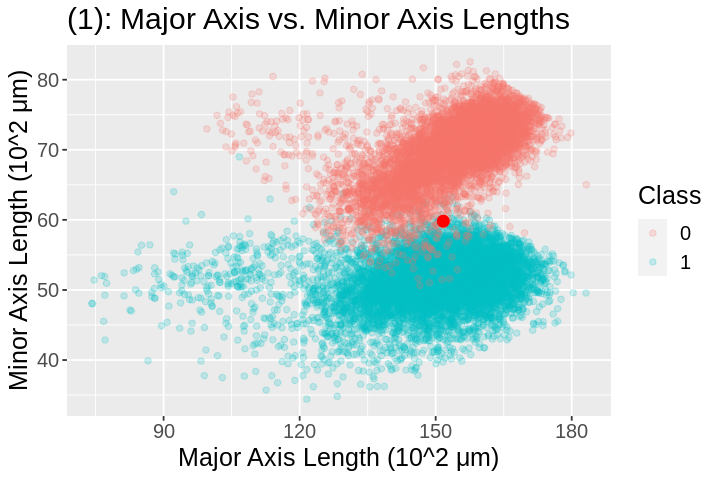

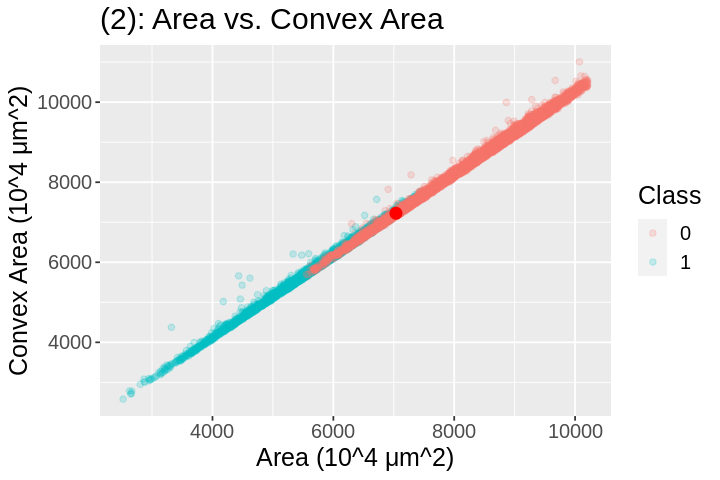

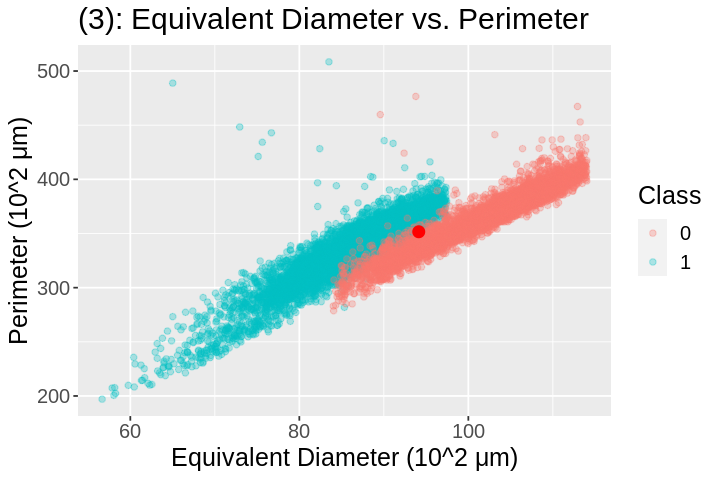

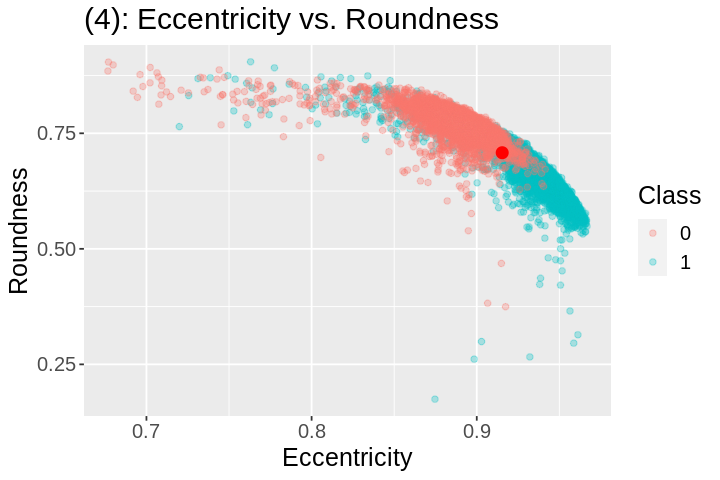

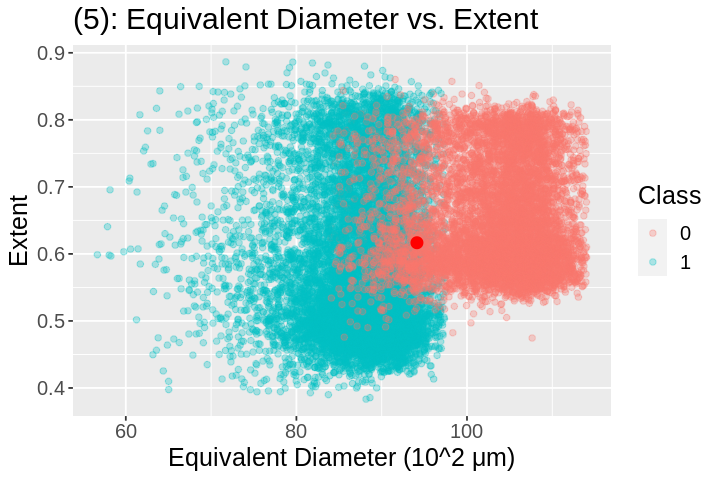

In [5]:
options(repr.plot.width=6,repr.plot.height=4)
#MajorAxisLength vs MinorAxisLength
ggplot(rice_data, aes(x=MajorAxisLength, y = MinorAxisLength, color=Class)) +
    geom_point(alpha=0.2) + 
    ggtitle("(1): Major Axis vs. Minor Axis Lengths")  +
    labs(x = "Major Axis Length (10^2 μm)",
         y = "Minor Axis Length (10^2 μm)") +
    geom_point(data=test_obs,
             aes(x=MajorAxisLength,y=MinorAxisLength), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#Area vs ConvexArea
ggplot(rice_data, aes(x=Area, y = ConvexArea, color=Class)) +
    geom_point(alpha=0.2) + 
    ggtitle("(2): Area vs. Convex Area")  +
    labs(x = "Area (10^4 μm^2)",
         y = "Convex Area (10^4 μm^2)") +
    geom_point(data=test_obs,
             aes(x=Area,y=ConvexArea), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#EquivDiameter vs Perimeter
ggplot(rice_data, aes(x=EquivDiameter, y = Perimeter, color=Class)) +
    geom_point(alpha=0.3) + 
    ggtitle("(3): Equivalent Diameter vs. Perimeter")  +
    labs(x = "Equivalent Diameter (10^2 μm)",
         y = "Perimeter (10^2 μm)") +
    geom_point(data=test_obs,
             aes(x=EquivDiameter,y=Perimeter), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#Eccentricity vs Roundness
ggplot(rice_data, aes(x=Eccentricity, y = Roundness, color=Class)) +
    geom_point(alpha=0.3) + 
    ggtitle("(4): Eccentricity vs. Roundness")  +
    labs(x = "Eccentricity",
         y = "Roundness") +
    geom_point(data=test_obs,
             aes(x=Eccentricity,y=Roundness), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

#EquivDiameter vs Extent
ggplot(rice_data, aes(x=EquivDiameter, y = Extent, color=Class)) +
    geom_point(alpha=0.3) + 
    ggtitle("(5): Equivalent Diameter vs. Extent")  +
    labs(x = "Equivalent Diameter (10^2 μm)",
         y = "Extent") +
    geom_point(data=test_obs,
             aes(x=EquivDiameter,y=Extent), 
             color='red',
             size=3) +
    theme(text = element_text(size=15))

### -> Selecting predictors

We will omit the following predictors from our classifier model:

* **id**: The unique identifier for each observation
* **ConvexArea**: Has a strong positive relationship with Area. Since we can accurately estimate ConvexArea using Area, there is no need to keep both variables in the dataset.
* **AspectRation**: Is calculated by dividing length by width, which is unneeded if we have measurements for MajorAxisLength (length) and MinorAxisLength (width).
* **Roundness**: Feature is similar to Eccentricity (both represent the deviation from the curve)

This leaves us with seven predictors. However, we are also uncertain of the effectivenes of the two predictors below:

* **MajorAxisLength**: No distinct distribution between two classes, therefore may not be useful for effective classification (see first plot above).
* **Extent**: Like MajorAxisLength, the distribution of values is not very distinct for each class (see last plot above).

Therefore, to test the usefulness of these two predictors, during our analysis, we will create four separate recipes as follows:

    * other predictors + none
    * other predictors + MajorAxisLength
    * other predictors + Extent
    * other predictors + MajorAxisLength + Extent
    
... and choose the recipe that gives the highest accuracy in the classifier model.

### -> Data analysis with steps

##### i) Splitting the data

We first split our data into training and testing data, with 75% of our data going to the training set.

In [6]:
set.seed(5431)

rice_split <- initial_split(rice_data, prop = 3/4, strata = Class)  
rice_train <- training(rice_split)   
rice_test <- testing(rice_split)
#rice_train
#rice_test

We should also make sure that test_obs, the observation we will classify in the end, is not in the training model. Otherwise, our model would already have the test_obs installed in its model, which is not ideal. 

In [7]:
#Confirm our observation in question is in testing set.
filter(rice_test, id == 9056)

id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
9056,7036,151.6808,59.80785,0.9154064,7225,94.13249,0.6166529,351.607,0.7079983,2.599081,0


##### ii) Creating a tuning model and setting up for cross validation

In [8]:
set.seed(5432)

#Standard tuning model for KNN classification (we set the number of neighbors as a variable using tune().)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

#Spliting training data up for 10-fold cross validation.
rice_vfold <- vfold_cv(rice_train, v = 5, strata = Class)

##### iii) Creating the recipes

As mentioned in the predictor selection step, we will create 4 recipes, each with their own predictor combination. The combinations are commented below, and also listed above in "Selecting Predictors".

In [9]:
set.seed(5432)

#Recipe with permanent predictors + MajorAxisLength
recipe_1 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter + MajorAxisLength,
                   data = rice_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#Recipe with permanent predictors + Extent
recipe_2 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter + Extent,
                   data = rice_train)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#Recipe with permanent predictors + MajorAxisLength + Extent
recipe_3 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter + MajorAxisLength + Extent,
                   data = rice_train)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#Recipe with permanent predictors only
recipe_4 <- recipe(Class ~ MinorAxisLength + Eccentricity + EquivDiameter + Perimeter,
                   data = rice_train)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

##### iii) Tuning the model and choosing the best K for each recipe

For each recipe, we will find the best accuracy by tuning for K values from a range of [2,50].

In [10]:
# List of K values we will test.

k_vals <- tibble(neighbors = seq(from=1,to=10,by=1)) 
# If the best K value turns out to be 10, we will retest different K values within a larger range.

In [11]:
# ACCURACY TEST FOR RECIPE_1

k_accuracy_1 <- workflow() |>
       
    # we tune for the best K on recipe 1
       add_recipe(recipe_1) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>     # collects the highest k parameter as well as the accuracy it gives
                       # (for this specific choice of predictors)
       select(neighbors, mean)

k_accuracy_1

neighbors,mean
<dbl>,<dbl>
7,0.9888546


In [12]:
# ACCURACY TEST FOR RECIPE_2

# Repeating the process of the first recipe:

k_accuracy_2 <- workflow() |>
       
    # we tune for the best K on recipe 2
       add_recipe(recipe_2) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>
       select(neighbors, mean)

k_accuracy_2

neighbors,mean
<dbl>,<dbl>
9,0.988268


In [13]:
# ACCURACY TEST FOR RECIPE_3

k_accuracy_3 <- workflow() |>
       
    # we tune for the best K on recipe 3
       add_recipe(recipe_3) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>
       select(neighbors, mean)

k_accuracy_3

neighbors,mean
<dbl>,<dbl>
7,0.9884147


In [14]:
# ACCURACY TEST FOR RECIPE_4

k_accuracy_4 <- workflow() |>
       
    # we tune for the best K on recipe 4
       add_recipe(recipe_4) |>
       add_model(knn_tune) |>
       tune_grid(resamples = rice_vfold, grid = k_vals) |>
       collect_metrics() |>

    # filter the result and find the parameter k with the highest accuracy

       filter(.metric == "accuracy") |>
       arrange(desc(mean)) |>
       slice(1) |>
       select(neighbors, mean)

k_accuracy_4

neighbors,mean
<dbl>,<dbl>
9,0.9890012


##### iv) Making a model with the best recipe, using the best parameter K

We determine that the best recipe would be **recipe 4**, as it provides both the highest accuracy (although it is a marginal amount; we will discuss this later) and it requires the least number of predictors. In other words,  recipe 4 provides the best trade-off between accuracy and number of predictors.

In [15]:
set.seed(5432)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |> 
       set_engine("kknn") |>                    #best k value for the recipe we have chosen (see above)
       set_mode("classification")

# we fit the final model in a workflow model and finalize our classifier.
rice_fit <- workflow() |>
       add_recipe(recipe_4) |>
       add_model(knn_spec) |>
       fit(data = rice_train)

##### v) Evaluating the estimated accuracy of the classifier

We determine the accuracy of our final classifier by finding the accuracy of our classifier on our training set.

In [16]:
# we use the predict() function, the pull the value of the accuracy metric
set.seed(5432)

rice_test_accuracy <- predict(rice_fit, rice_test) |>
    bind_cols(rice_test) |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull()

rice_test_accuracy

[1] 0.9894459

##### vi) Classifying test_obs

Finally, we get the observation we pulled initially (the one with fairly neutral measurements), and see if the classifier predicts correctly. (Recall the real class for the observation is **Gonen (0)**).

In [17]:
rice_neutral_prediction <- predict(rice_fit , test_obs)
rice_neutral_prediction

.pred_class
<fct>
0


## 3.  Discussion

As expected, our final classifier has correctly predicted the class of our rice observation of "neutral" properties as Gonen (0).

We realized that this result was due to the unusually high accuracy rate of our classifier, which occurs for the following reasons: first, this data was collected for the purpose of binary classification, and the two classes presented are visibly distinct in their physical features (as shown in the plots above, under "Visualisations"). As well, since there are literally thousands of observations which our classifier can use, the dataset is more dense and "accurate" (better representing the entire population Gonen and Jasmine rice), and therefore is expected to produce a more accurate result. We prove this under step (v) of Methods and Results, as the accuracy rate was shown to be almost 99%, which is almost too high compared to the examples shown during lecture. 

Therefore, through this analysis, we are able to understand how the size of the dataset and the distribution of classes affect the performance of KNN classification; we consider the possibility that the size of a dataset in relation to a KNN classification model is similar to the size of a sample in relation to statistical inference (in the sense that as the size of the sample increases, the sample better represents the entire population). As a result, despite our observation being relatively neutral in its measurements, due to the dataset size and the way the classes were distributed, our classfier was able to predict its correct class. 

We also recognize the significance within the context of the dataset, as automated rice classification is recommended and already being used in some factories to "ensure the timely certification of rice." With a proper dataset and the right choice of predictors, KNN classification would be able to separate rice (or any type of crops/seeds) into their respective category, which could be useful in commercial settings.

Finally, we acknowledge that our project could be further improved through reducing the work of the classifier. We noticed that building and running our final classifier took a significant amount of time, which was due to the thousands of observations combined with the numerous K values we had to test for each recipe. The first solution we thought of was further reducing the number of predictors used in the classifier; once again, the plots we generated under "Visualizations" show that some variables demonstrate a significant distinction between the two classes. If we used only 3 variables of this kind, the accuracy would obviously decrease (as we have less predictors), however it may provide a better trade-off between efficiency and accuracy overall. For k values, we can probably choose a smaller k value without losing too much accuracy, as the dataset densely packed with thousands of observations such that we cannot easily overfit it. Therefore, when we choose a smaller value of k, we can greatly shorten the time of data processing by sacrificing a marginal loss of accuracy.

## 4. References



- MsSmartyPants. “Rice Type Classification.” Kaggle, 30 June 2021, www.kaggle.com/datasets/mssmartypants/rice-type-classification. 
- Publisher, IRJET. “IRJET- Application of Big Data Tools for Seed Classification.”Issuu, 10 Feb. 2021, issuu.com/irjet/docs/irjet-v8i1182. 
- SARIGİL, Seyma. “Rice Seed Dataset (Gonen&amp;Jasmine).” Kaggle, 24 Feb. 2020, www.kaggle.com/datasets/seymasa/rice-dataset-gonenjasmine. 
- Ουγιαρόγλου, Στέφανος. “Algorithms and Techniques for Efficient and Effective Nearest Neighbours Classification.” doi:10.12681/eadd/34608. 